In [1]:
import os
import os.path as path
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy
import pickle
from ipdb import set_trace

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

In [2]:
BATTLE_MOCK = '/home/leo/groups/leo1994122701/Mockingjay'
D_MOCK = '/home/leo/d/Mockingjay'
LIBRISPEECH = '/home/leo/d/dataset/LibriSpeech'
LIBRI_PREPROCESS = 'data/libri_mel160_subword5000'
PHONES_TEST = 'data/libri_phone/test-clean'
PHONES_CODE = 'data/libri_phone/phone2idx.pkl'

models = [
    'result/result_mockingjay/mockingjay_libri_sd1337_LinearLarge/mockingjay-500000-dump/',
    'result/result_mockingjay/mockingjay_libri_sd1337_MelBase/mockingjay-500000-dump/',
    'result/result_mockingjay/mockingjay_phone_libri_sd1337_MelBaseFT2_1/mockingjay_phone-58000-dump/',
    'result/result_mockingjay/mockingjay_libri_sd1337_MelLargeM6/mockingjay-500000-dump/',
    'result/result_mockingjay/mockingjay_libri_sd1337_MelLargeM9/mockingjay-500000-dump/',
]
ATTNS = models[0]

phone2idx = pickle.load(open(path.join(D_MOCK, PHONES_CODE), 'rb'))
id2phone = {}
for key in phone2idx.keys():
    id2phone[phone2idx[key]] = key

test_csv = path.join(D_MOCK, LIBRI_PREPROCESS, 'test-clean.csv')
test_csv = pd.read_csv(test_csv)
test_csv.iloc[:5]

,Unnamed: 0,file_path,length,label
0,0,test-clean/4507-16021-0047.npy,2797,0_2295_22_49_2815_20_8_1546_13_25_332_7_22_7_1...
1,1,test-clean/1995-1836-0004.npy,2713,0_23_31_2677_12_28_1875_4_31_4129_12_3_562_19_...
2,2,test-clean/7021-79730-0003.npy,2631,0_23_3_1111_222_35_1871_4_181_1041_704_4_4403_...
3,3,test-clean/908-157963-0007.npy,2622,0_3_503_144_34_6_3_1530_828_16_9_3_2978_1522_5...
4,4,test-clean/2094-142345-0008.npy,2533,0_29_55_25_272_8_3331_643_6_180_59_3_404_25_26...


In [3]:
file_id = 51
selected_file_info = test_csv.iloc[file_id]
file_name = selected_file_info.file_path.split('/')[-1].replace('.npy', '')
attentions = torch.load(path.join(D_MOCK, ATTNS, f'{file_id}_attentions'))
phones = pickle.load(open(path.join(D_MOCK, PHONES_TEST, f'{file_name}.pkl'), 'rb'))
phones = phones[np.arange(0, phones.shape[-1], 3)]
min_dim = min(selected_file_info.length // 3, attentions.size(-1), phones.shape[0])

attentions = attentions[:, :, :min_dim, :min_dim]
phones = phones[:min_dim]

phones_binary = np.zeros(phones.shape[0])
last_phone = -1
current_symbol = False
for i, phone in enumerate(phones):
    if phone != last_phone:
        last_phone = phone
        current_symbol = not current_symbol
    phones_binary[i] = int(current_symbol)

## Head mean of each layer

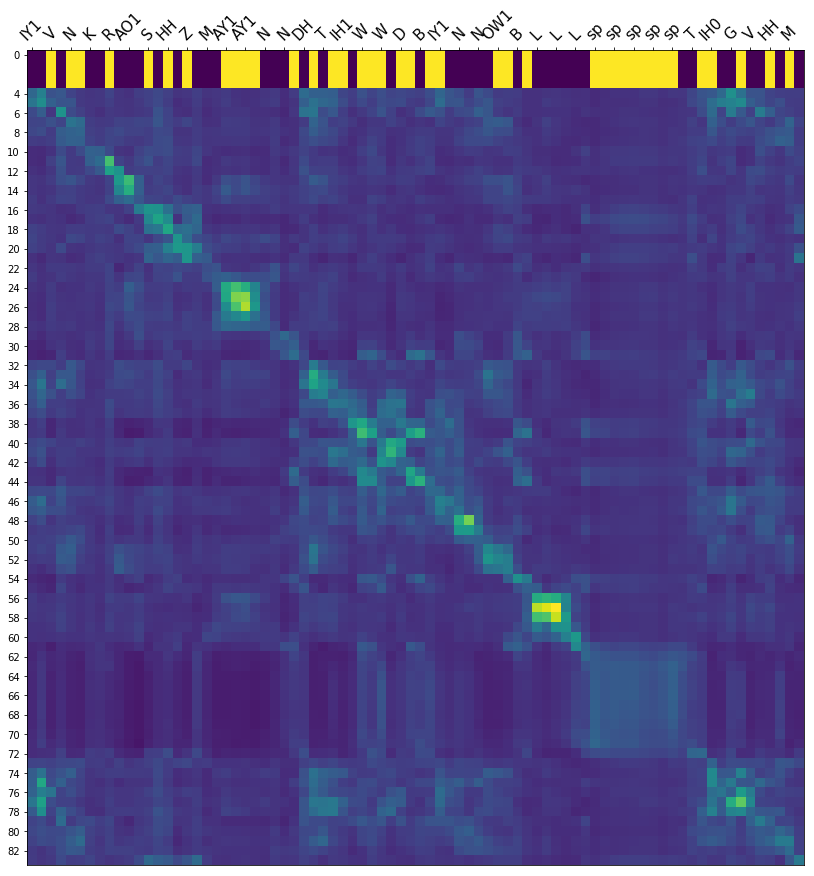

In [4]:
# attn_map = deepcopy(attentions[3, 11])
attn_map = deepcopy(attentions[11].mean(dim=0))
start = 220
end = 300
band_height = int((end - start) * 0.05)
attn_map = attn_map[start:end]
attn_map = np.vstack([np.tile(phones_binary * attn_map.max().item(), (band_height, 1)), attn_map])
attn_map = attn_map[:, start:end]
selected_phones = phones[start:end]

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
img = ax.imshow(attn_map)

indexes = np.arange(0, len(selected_phones), 2)
sampled_phones = selected_phones[indexes]
x_label_list = [ id2phone[phone_idx] for phone_idx in sampled_phones]

ax.set_xticks(indexes)
ax.set_yticks([0] + list(indexes + band_height))
ax.set_xticklabels(x_label_list, fontsize=15, rotation=45)
# ax.grid(color='g', linestyle='-', linewidth=1)
img

## Head summary of each layer

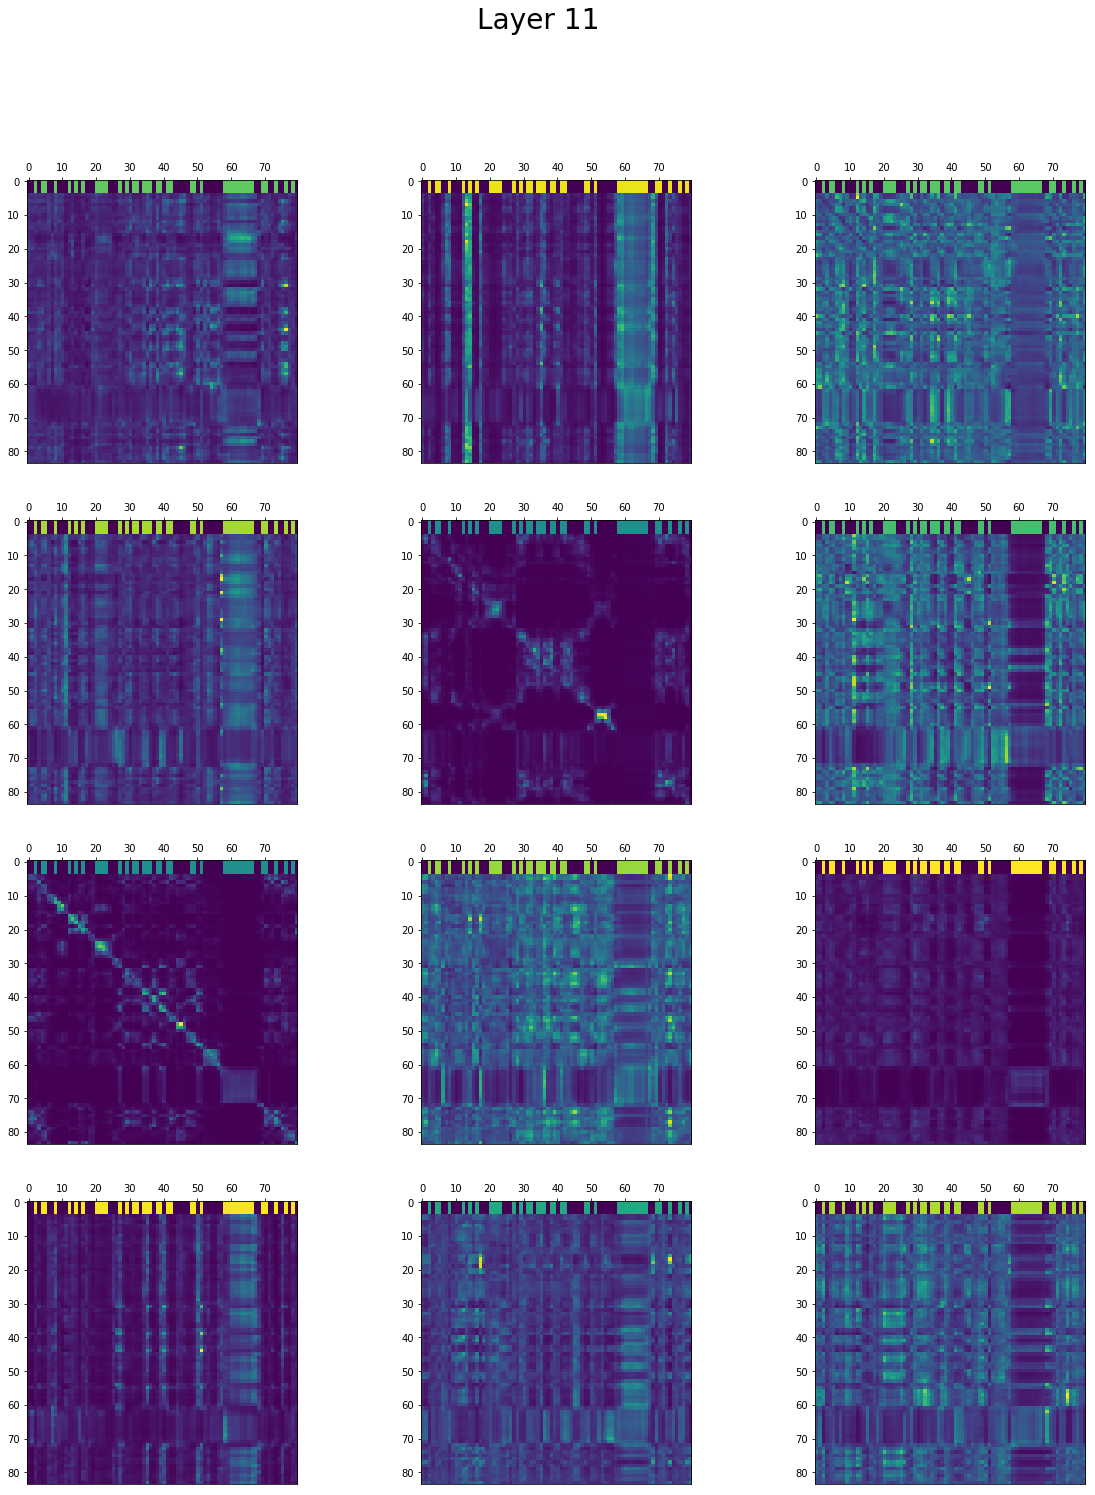

In [5]:
layer = 11
row_num = 4
col_num = 3
start = 220
end = 300
band_height = int((end - start) * 0.05)
topk = None
exp = False

fig, axs = plt.subplots(row_num, col_num, figsize=(20, 24))
fig.suptitle(f'Layer {layer}', fontsize=28)
for idx in range(row_num * col_num):
    row = idx // col_num
    col = idx % col_num
    ax = axs[row][col]
    
    attn_map = deepcopy(attentions[layer, idx])
    
    if topk is not None:
        binary = torch.zeros(attn_map.shape)
        for row_id, row in enumerate(attn_map):
            _, indices = row.topk(topk)
            binary[row_id, indices] = 0.5
        attn_map = binary
    
    if exp:
        sharpened = []
        for _, row in enumerate(attn_map):
            sharpened.append(F.softmax(row / row.max(), dim=-1))
        attn_map = torch.stack(sharpened)
    
    attn_map = attn_map[start:end]
    attn_map = np.vstack([np.tile(phones_binary * attn_map.max().item() * 0.5, (band_height, 1)), attn_map])
    attn_map = attn_map[:, start:end]
    selected_phones = phones[start:end]
    
    img = ax.imshow(attn_map)
    indexes = np.arange(0, len(selected_phones), 10)
    sampled_phones = selected_phones[indexes]
    x_label_list = [ id2phone[phone_idx] for phone_idx in sampled_phones]